## Analysis of velocity gradient quantities in the surface ocean of LLC4320 

[LLC4320](https://online.kitp.ucsb.edu/online/blayers18/menemenlis/) is one of the highest resolution simulations of the global ocean. 

The data for the variables at the surface ocean are saved on google cloud at https://catalog.pangeo.io/browse/master/ocean/LLC4320/. 

In [1]:
# Load some useful modules 
import numpy as np
import xarray as xr
import xrft
from xmitgcm import llcreader
from matplotlib import pyplot as plt
import cmocean.cm as cm

%matplotlib inline

In [2]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml")

In [3]:
# Get variables from catalog
sst = cat.LLC4320_SST.to_dask()
sss = cat.LLC4320_SSS.to_dask()
ssh = cat.LLC4320_SSH.to_dask()
u = cat.LLC4320_SSU.to_dask()
v = cat.LLC4320_SSV.to_dask()


In [4]:
sst

,Array,Chunk
Bytes,8.76 TB,74.65 MB
Shape,"(9030, 13, 4320, 4320)","(1, 1, 4320, 4320)"
Count,117391 Tasks,117390 Chunks
Type,float32,numpy.ndarray


#### Model grid 

The full ocean is split into 13 tiles, with each tile having size 4320X4320. The simulations output is saved for every hour for 9030 hours (376.25 days). 

The data can be played around directly on the tiles, or [xmitgcm](https://xmitgcm.readthedocs.io/en/latest/) helper function `llcreader.llcmodel.faces_dataset_to_latlon()` can be used to transform to a stitched together global lat-lon grid (leaving out the Arctic).  


In [6]:
ds = xr.merge([sst, sss,ssh, u, v])
ds = llcreader.llcmodel.faces_dataset_to_latlon(ds, metric_vector_pairs=[])

coords = cat.LLC4320_grid.to_dask().reset_coords()
coords = llcreader.llcmodel.faces_dataset_to_latlon(coords)

In [7]:
# Get data on a single face 
ds_face = xr.merge([ssh.sel(face=1), sst.sel(face=1), sss.sel(face=1), 
               u.sel(face=1), v.sel(face=1)])

# Get coordiantes from the catalog
coords_face = (cat.LLC4320_grid.to_dask()).sel(face=1)

In [8]:
ds # this is on the transformed grid

<xarray.Dataset>
Dimensions:  (face: 13, i: 17280, i_g: 17280, j: 12960, j_g: 12960, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 9030)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89 90
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
Data variables:
    SST      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SSS      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(9030,), meta=np.ndarray>
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    U        (time, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    V        (time, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


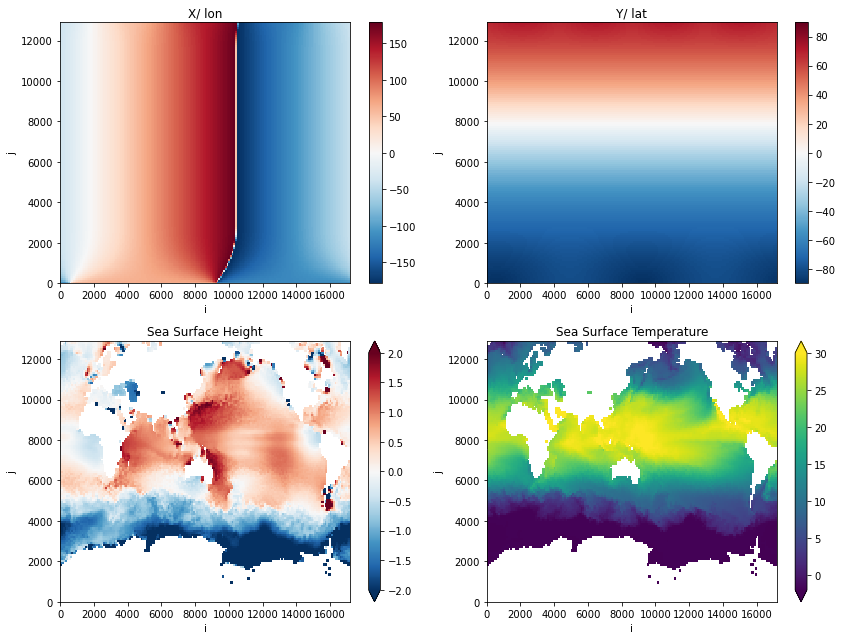

In [12]:
plt.figure(figsize=(12,9))

plt.subplot(221)
ds.XC.coarsen(i=100, j=100, boundary='trim').mean().plot()
plt.title('X/ lon')

plt.subplot(222)
ds.YC.coarsen(i=100, j=100, boundary='trim').mean().plot()
plt.title('Y/ lat')

plt.subplot(223)
ds.Eta.isel(time=-1).coarsen(i=100, j=100, boundary='trim').mean().plot(vmin=-2)
plt.title('Sea Surface Height')

plt.subplot(224)
ds.SST.isel(time=-1).coarsen(i=100, j=100, boundary='trim').mean().plot(vmin=-2, vmax=30)
plt.title('Sea Surface Temperature')

plt.tight_layout()

### Calc quantities with gradients

To understand the nature of the small scale flows we often consider the statistics of the gradient quantities. 

Gradients can be computed and the quantities moved around to the correct grid points using [xgcm](https://xgcm.readthedocs.io/en/latest/xgcm-examples/02_mitgcm.html).

In [8]:
import xgcm
grid = xgcm.Grid(coords.drop(['k', 'k_p1']), periodic=None)

In [14]:
# Compute the gradients (this will most likely fail)

u_transport = ds.U * coords.dyG 
v_transport = ds.V * coords.dxG 

# Divergence
div_uv = (grid.diff(u_transport, 'X', boundary='extend') + grid.diff(v_transport, 'Y', boundary='extend')) / coords.rA

# Vorticity
zeta = (-grid.diff(ds.U * coords.dxC, 'Y', boundary='extend') + grid.diff(ds.V * coords.dyC, 'X', boundary='extend'))/coords.rAz
zeta = grid.interp(grid.interp(zeta, 'X', boundary='extend'), 'Y', boundary='extend')

# Strain
strain1 = (grid.diff(ds.U * coords.dyG, 'X', boundary='extend') - grid.diff(ds.V * coords.dxG, 'Y',boundary='extend')) / coords.rA
strain2 = (grid.diff(ds.U * coords.dxC, 'Y', boundary='extend') + grid.diff(ds.V * coords.dyC, 'X', boundary='extend'))/coords.rAz
strain2 = grid.interp(grid.interp(strain2, 'X', boundary='extend'), 'Y', boundary='extend')
strain = (strain1**2 + strain2**2)**0.5

In [17]:
div_uv

,Array,Chunk
Bytes,8.09 TB,74.60 MB
Shape,"(9030, 12960, 17280)","(1, 4318, 4319)"
Count,9220121 Tasks,650160 Chunks
Type,float32,numpy.ndarray


In [10]:
# Compute the gradients (this will most likely work as it is a single face)
grid = xgcm.Grid(coords_face.drop(['k', 'k_p1']), periodic=None)

# Divergence
div_uv = (grid.diff(ds_face.U * coords_face.dyG, 'X', boundary='extend') + grid.diff(ds_face.V * coords_face.dxG , 'Y', boundary='extend')) / coords_face.rA

# Vorticity
zeta = (-grid.diff(ds_face.U * coords_face.dxC, 'Y', boundary='extend') + grid.diff(ds_face.V * coords_face.dyC, 'X', boundary='extend'))/coords_face.rAz
zeta = grid.interp(grid.interp(zeta, 'X', boundary='extend'), 'Y', boundary='extend')

# Strain
strain1 = (grid.diff(ds_face.U * coords_face.dyG, 'X', boundary='extend') - grid.diff(ds_face.V * coords_face.dxG, 'Y',boundary='extend')) / coords_face.rA
strain2 = (grid.diff(ds_face.U * coords_face.dxC, 'Y', boundary='extend') + grid.diff(ds_face.V * coords_face.dyC, 'X', boundary='extend'))/coords_face.rAz
strain2 = grid.interp(grid.interp(strain2, 'X', boundary='extend'), 'Y', boundary='extend')
strain = (strain1**2 + strain2**2)**0.5

In [18]:
f = 2*(2*np.pi/24/3600)*np.sin(coords_face.YC*np.pi/180)

In [34]:
lon = coords_face.XC.sel(j=0)
lat = coords_face.YC.sel(i=0)

In [56]:
div_norm = (div_uv/np.abs(f)).rename('Divergence')
zeta_norm = (zeta/f).rename('Vorticity')
strain_norm = (strain/np.abs(f)).rename('Strain')

In [57]:
zeta_norm

<xarray.DataArray 'Vorticity' (time: 9030, j: 4320, i: 4320)>
dask.array<truediv, shape=(9030, 4320, 4320), dtype=float32, chunksize=(1, 4318, 4318), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    CS       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    PHrefC   float32 ...
    SN       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    Z        float32 ...
    Zl       float32 ...
    Zu       float32 ...
    drF      float32 ...
    face     int64 1
    hFacC    (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    k        int64 ...
    k_l      int64 ...
    k_u      int64 ...
    rA       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>

<ipython-input-44-dcefae326ae7>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lon, lat, zeta_norm.isel(time=-1), vmin=-1, vmax=1, cmap='RdBu_r')


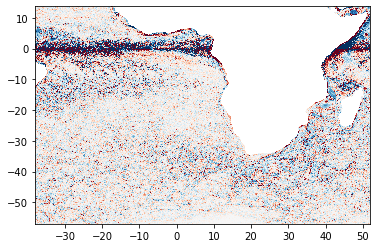

In [44]:
plt.pcolormesh(lon, lat, zeta_norm.isel(time=-1), vmin=-1, vmax=1, cmap='RdBu_r')

<ipython-input-49-30de46da1405>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lon.sel(i=isel),


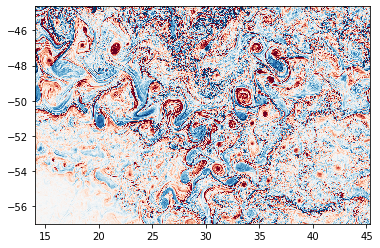

In [49]:
isel = slice(2500, 4000)
jsel = slice(0, 1000)
plt.pcolormesh(lon.sel(i=isel),
               lat.sel(j=jsel),
               zeta_norm.isel(time=-1).sel(i=isel, j=jsel),
               vmin=-0.5, vmax=0.5, cmap='RdBu_r')


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
<ipython-input-51-2ce6e4793227>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lon.sel(i=isel),


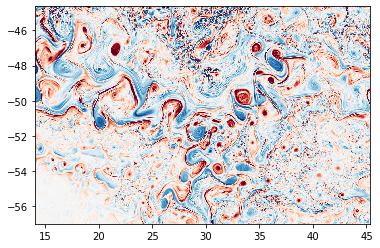

In [51]:
isel = slice(2500, 4000)
jsel = slice(0, 1000)
plt.pcolormesh(lon.sel(i=isel),
               lat.sel(j=jsel),
               zeta_norm.isel(time=slice(-24,-1)).mean('time').sel(i=isel, j=jsel),
               vmin=-0.5, vmax=0.5, cmap='RdBu_r')

# A lot of very high frequency signal can be removed by averaging over a day

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


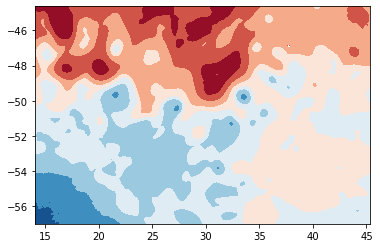

In [53]:
isel = slice(2500, 4000)
jsel = slice(0, 1000)
plt.contourf(lon.sel(i=isel),
               lat.sel(j=jsel),
               ds_face.Eta.isel(time=slice(-24,-1)).mean('time').sel(i=isel, j=jsel),
               cmap='RdBu_r')
# Different fields have different roughness

### Histograms 

We use [xhistogram](https://xhistogram.readthedocs.io/en/latest/) or [boost_histogram](https://boost-histogram.readthedocs.io/en/latest/notebooks/xarray.html) (about 5 times faster) to make histograms of these quantities, since different gradient quantities tend to be correlated. 

In [54]:
from xhistogram.xarray import histogram

In [81]:
vort_bins = np.linspace(-4, 4, 120)
strain_bins = np.linspace(0, 4, 120)


hist_zeta_strain = histogram(zeta_norm.sel(i=isel, j=jsel),
                             strain_norm.sel(i=isel, j=jsel),
                             dim = ['i','j'] , 
                             bins=[vort_bins,strain_bins])

In [82]:
hist_zeta_strain

<xarray.DataArray 'histogram_Vorticity_Strain' (time: 9030, Vorticity_bin: 119, Strain_bin: 119)>
dask.array<getitem, shape=(9030, 119, 119), dtype=int64, chunksize=(1, 119, 119), chunktype=numpy.ndarray>
Coordinates:
  * time           (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * Vorticity_bin  (Vorticity_bin) float64 -3.966 -3.899 -3.832 ... 3.899 3.966
  * Strain_bin     (Strain_bin) float64 0.01681 0.05042 0.08403 ... 3.95 3.983

In [84]:
dzetaXdstrain = (vort_bins[1]-vort_bins[0])*(strain_bins[1]-strain_bins[0])
Npts = hist_zeta_strain.sum(['Vorticity_bin','Strain_bin'])
Jpdf_vorticity_strain = hist_zeta_strain/dzetaXdstrain/Npts

In [74]:
from matplotlib import colors as cols

In [86]:
Jpdf_ann_mean = Jpdf_vorticity_strain.isel(time=slice(0, 9000, 100)).mean('time')

In [88]:
Jpdf_ann_mean.load()

<xarray.DataArray 'histogram_Vorticity_Strain' (Vorticity_bin: 119, Strain_bin: 119)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * Vorticity_bin  (Vorticity_bin) float64 -3.966 -3.899 -3.832 ... 3.899 3.966
  * Strain_bin     (Strain_bin) float64 0.01681 0.05042 0.08403 ... 3.95 3.983

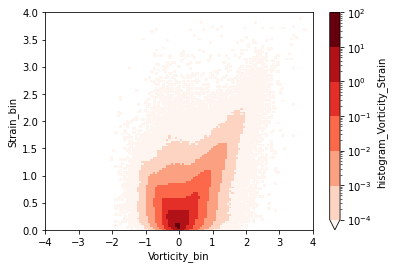

In [89]:
(Jpdf_ann_mean.T).plot(levels=np.logspace(-4,2, 7), 
                       norm=cols.LogNorm(vmin=1e-4, vmax=1e2), 
                       cmap ='Reds', rasterized=True)

In [91]:
# Start computing the conditional mean for divergence

conditional_hist_div = histogram(zeta_norm.sel(i=isel, j=jsel),
                             strain_norm.sel(i=isel, j=jsel),
                             weights=div_norm.sel(i=isel, j=jsel),
                             dim = ['i','j'] , 
                             bins=[vort_bins,strain_bins])

In [92]:
conditional_mean_div = conditional_hist_div/hist_zeta_strain

In [93]:
conditional_mean_div

<xarray.DataArray 'histogram_Vorticity_Strain' (time: 9030, Vorticity_bin: 119, Strain_bin: 119)>
dask.array<truediv, shape=(9030, 119, 119), dtype=float64, chunksize=(1, 119, 119), chunktype=numpy.ndarray>
Coordinates:
  * time           (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * Vorticity_bin  (Vorticity_bin) float64 -3.966 -3.899 -3.832 ... 3.899 3.966
  * Strain_bin     (Strain_bin) float64 0.01681 0.05042 0.08403 ... 3.95 3.983

In [99]:
conditional_mean_div_ann_mean = conditional_mean_div.isel(time=slice(0, 9000, 100)).mean('time')

In [100]:
conditional_mean_div_ann_mean.load()

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'histogram_Vorticity_Strain' (Vorticity_bin: 119, Strain_bin: 119)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * Vorticity_bin  (Vorticity_bin) float64 -3.966 -3.899 -3.832 ... 3.899 3.966
  * Strain_bin     (Strain_bin) float64 0.01681 0.05042 0.08403 ... 3.95 3.983

<ipython-input-102-55c6a70d7121>:2: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm=cols.SymLogNorm(1e-1), cmap ='RdBu_r')


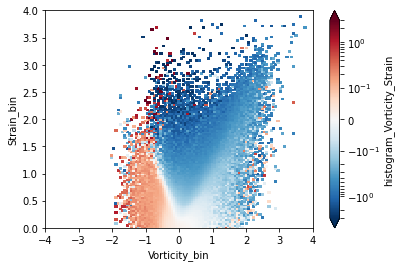

In [102]:
(conditional_mean_div_ann_mean.T).plot(vmin=-3, vmax=3, 
                                   norm=cols.SymLogNorm(1e-1), cmap ='RdBu_r')

### Other heroic tasks
- Compute spectra in region selected interactively by box on map using xrft